In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, StepLR, OneCycleLR
from pathlib import Path
import matplotlib.animation as animation
from sklearn.datasets import *



from rich import print
import imageio


from utils.Models import MLP
from utils.Datasets import BBdataset
from utils.utils import *
seed = 233
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 1
print(f"Using device: {device}")


experiment_name = "gaussian2S_2model"  # 你可以根据需要动态设置这个变量
# log_dir = Path('experiments') / experiment_name / 'test' / time.strftime("%Y-%m-%d/%H_%M_%S/")
log_dir = Path('experiments') / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using device: 1

In [2]:
# 生成初始和目标密度样本
def gen_data(m=4, num_samples=1000):
    mus = [(m, m), (m, -m), (-m, m), (-m, -m)]
    source_dist = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], num_samples)
    target_dist = make_s_curve(n_samples=num_samples, noise=0.01)[0][:, ::2] * 2
    return source_dist, target_dist

# 生成二维Brownian bridge
def gen_bridge_2d(x, y, ts, T, num_samples):
    sigma = 1
    bridge = torch.zeros((ts.shape[0], num_samples, 2))
    drift = torch.zeros((ts.shape[0], num_samples, 2))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

# 主函数
def gen_2d_data(m=4, num_samples=1000, epsilon=0.001, T=1):
    if not isinstance(num_samples, int):
        num_samples = int(num_samples)
    source_dist, target_dist = gen_data(m, num_samples)
        
    epsilon1 = 0.001
    epsilon2 = 0.0001

    t1 = torch.arange(0, 0.91, epsilon1)
    t2 = torch.arange(0.91, T, epsilon2)
    ts = torch.concatenate((t1, t2))
    
    source_dist = torch.Tensor(source_dist)
    target_dist = torch.Tensor(target_dist)
    bridge, drift = gen_bridge_2d(source_dist, target_dist, torch.concatenate((t1, t2)), T=T, num_samples=num_samples)
    
    a_min = torch.min(t2)
    a_max = torch.max(t2)
    t2 = (t2 - a_min) / (a_max - a_min)
    return t1, t2, ts, bridge, drift, source_dist, target_dist

t1, t2, ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=1000)

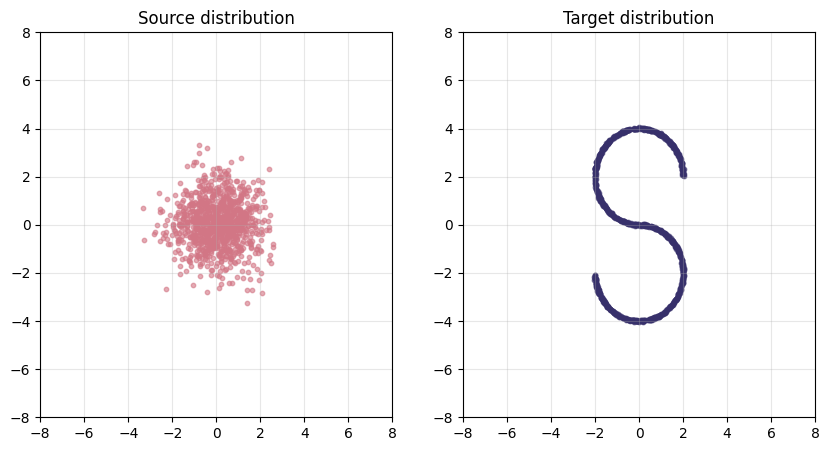

In [3]:
def plot_source_and_target(sour, targ, left_title="Source distribution", right_title="Target distribution", save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].scatter(*sour.T, c='#D27685', s=10, alpha=0.6)
    axs[1].scatter(*targ.T, c='#37306B', s=10, alpha=0.6)
    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    axs[0].grid(True, alpha=0.3)
    axs[1].grid(True, alpha=0.3)
    axs[0].set_xlim(-8, 8)
    axs[0].set_ylim(-8, 8)
    axs[1].set_xlim(-8, 8)
    axs[1].set_ylim(-8, 8)
    fig.show()
    if save_path is not None:
        fig.savefig(save_path)

plot_source_and_target(source_sample, target_sample)

In [4]:
def draw_gaussian2d(bridge, colors=True):
    def get_color(point):
        x, y = point
        if x > 0 and y > 0:
            return 0
        elif x > 0 and y < 0:
            return 1
        elif x < 0 and y > 0:
            return 2
        else:
            return 3

    # 生成数据
    color_list = ['#37306B', '#66347F', '#9E4784', '#D27685']  # 对应于目标均值的颜色

    # 创建3D图形
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 为每个样本绘制bridge
    for i in range(bridge.shape[1]):
        x = bridge[:, i, 0].numpy()  # X坐标
        y = bridge[:, i, 1].numpy()  # Y坐标
        z = ts.numpy()               # 时间作为Z坐标
        c = color_list[get_color((x[-1], y[-1]))] if colors else '#D27685'
        ax.plot(x, y, z, color=c, label=f'Sample {i+1}', alpha=0.3)

    # 添加标签和图例
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time')

    fig.show()

In [5]:
def draw_gaussian2d_gif(bridge):
    def get_color(point):
        x, y = point
        if x > 0 and y > 0:
            return 0
        elif x > 0 and y < 0:
            return 1
        elif x < 0 and y > 0:
            return 2
        else:
            return 3
    colors = ['b', 'g', 'r', 'c']  # 对应于目标均值的颜色
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    # 定义更新函数
    def update(frame):
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        for i in range(bridge.shape[1]):
            x = bridge[:frame + 1, i, 0].numpy()  # 注意：frame + 1
            y = bridge[:frame + 1, i, 1].numpy()  # 注意：frame + 1
            if x.size > 0 and y.size > 0:  # 确保x和y不为空
                color_index = get_color((x[-1], y[-1]))
                ax.plot(x, y, color=colors[color_index], alpha=0.5)
                ax.scatter(x[-1], y[-1], color=colors[color_index], alpha=1, s=10)
    # 创建动画
    ani = animation.FuncAnimation(fig, update, frames=len(ts), interval=100)
    # 保存为GIF需要花费6分钟左右
    ani.save(log_dir / 'brownian_bridge.gif', writer='imagemagick')

In [6]:
num_samples = 12000
t1, t2, ts, bridge, drift, source_sample, target_sample = gen_2d_data(num_samples=num_samples)
print_debug(ts, bridge, drift, source_sample, target_sample)

# split data
start1 = torch.cat(torch.split(source_sample.repeat(len(t1)-1, 1, 1), 1, dim=1), dim=0)
start2 = torch.cat(torch.split(source_sample.repeat(len(t2)-1, 1, 1), 1, dim=1), dim=0)

times1 = t1[:len(t1)-1].repeat(num_samples, 1).reshape(-1, 1, 1)
times2 = t2[:len(t2)-1].repeat(num_samples, 1).reshape(-1, 1, 1)

bridge1 = bridge[:len(t1), :, :]
bridge2 = bridge[len(t1):, :, :]

positions1 = torch.cat(torch.split(bridge1[:-1, :], 1, dim=1), dim=0)
positions2 = torch.cat(torch.split(bridge2[:-1, :], 1, dim=1), dim=0)

drift1 = drift[:len(t1), :, :]
drift2 = drift[len(t1):, :, :]

scores1 = torch.cat(torch.split(drift1[:-1, :], 1, dim=1), dim=0)
scores2 = torch.cat(torch.split(drift2[:-1, :], 1, dim=1), dim=0)


# start = torch.cat(torch.split(source_sample.repeat(len(ts)-1, 1, 1), 1, dim=1), dim=0)
# times = ts[:len(ts)-1].repeat(num_samples, 1).reshape(-1, 1, 1)
# positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)
# scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)

# print_debug(start1, times1, positions1, scores1)
raw_data1 = torch.concat([start1, times1, positions1, scores1], dim=-1)
raw_data2 = torch.concat([start2, times2, positions2, scores2], dim=-1)
raw_data1.shape

====================

torch.Size([1810])
torch.float32 cpu

torch.Size([1810, 12000, 2])
torch.float32 cpu

torch.Size([1810, 12000, 2])
torch.float32 cpu

torch.Size([12000, 2])
torch.float32 cpu

torch.Size([12000, 2])
torch.float32 cpu

torch.Size([10908000, 1, 7])

In [7]:
epochs = 50
batch_size = 100000
lr = 1e-4

# 组合成data
train_ds1 = BBdataset(raw_data1)
train_dl1 = DataLoader(train_ds1, batch_size=batch_size, shuffle=True, num_workers=20)

train_ds2 = BBdataset(raw_data2)
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True, num_workers=20)

model1 = MLP(input_dim=5, output_dim=2, hidden_layers=4, hidden_dim=256).to(device)
model2 = MLP(input_dim=5, output_dim=2, hidden_layers=4, hidden_dim=256).to(device)
loss_fn = nn.MSELoss()
loss_list1 = []
loss_list2 = []
print('='*10+'model'+'='*10)
print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl1.__iter__()).shape)) # batch_szie, channel, length
print(model1)

==========model==========

batch_szie:100000, channel:1, length:7

MLP(
  (fcin): Linear(in_features=5, out_features=256, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fcout): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)

In [8]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    for training_data in train_dl:
        training_data = training_data.to(device)
        # x: (batch_size, channel, length-2), y: (batch_size, channel, 2)
        x, y = training_data[:, 0, :-2], training_data[:, 0, -2:] # 不同模型要改
        # print(x.shape)
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses
from torch.optim.lr_scheduler import OneCycleLR

model1.train()
model1.to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-6)

model2.train()
model2.to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-6)

epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
for e in epoch_iterator:
    now_loss1 = train(model1, train_dl1, optimizer1, None, loss_fn)
    now_loss2 = train(model2, train_dl2, optimizer2, None, loss_fn)
    loss_list1.append(now_loss1)
    loss_list2.append(now_loss2)
    cur_lr = optimizer1.param_groups[-1]['lr']
    # cur_lr = optimizer1.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f)  (loss1=%2.5f) (loss2=%2.5f)" % (cur_lr, now_loss1, now_loss2))
    
epoch_iterator.close()

Training (lr: X)  (loss= X):   0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
for e in epoch_iterator:
    # now_loss1 = train(model1, train_dl1, optimizer1, None, loss_fn)
    now_loss2 = train(model2, train_dl2, optimizer2, None, loss_fn)
    # loss_list1.append(now_loss1)
    loss_list2.append(now_loss2)
    cur_lr = optimizer1.param_groups[-1]['lr']
    # cur_lr = optimizer1.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f) (loss2=%2.5f)" % (cur_lr, now_loss2))
    
epoch_iterator.close()

In [9]:
torch.save(model1.state_dict(), log_dir / 'model1.pth')
torch.save(model2.state_dict(), log_dir / 'model2.pth')

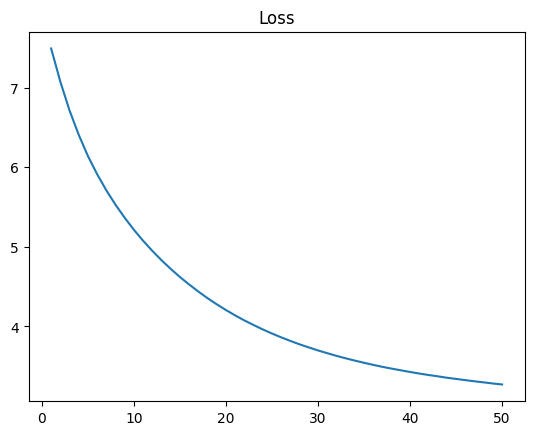

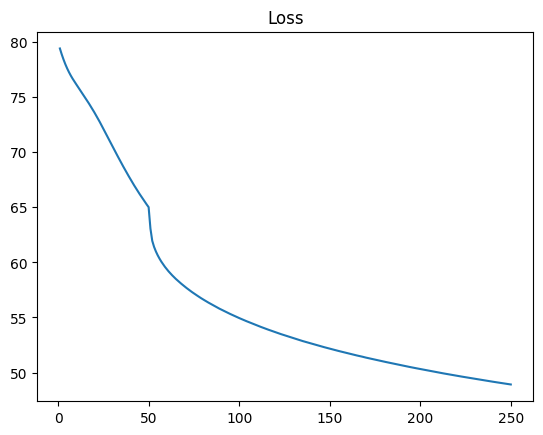

In [23]:
plt.plot(range(1, len(loss_list1)+1), loss_list1)
plt.title('Loss')
plt.show()

plt.plot(range(1, len(loss_list2)+1), loss_list2)
plt.title('Loss')
plt.show()

In [24]:
test_num_samples = 4000
_,_,test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = gen_2d_data(num_samples=test_num_samples)
# print_debug(test_ts, test_bridge, test_drift, test_source_sample, test_target_sample)
pred_bridge = torch.zeros_like(test_bridge)
pred_bridge[0, :] = test_source_sample
model1.eval()
model2.eval()
# model.to(device)
sigma=1
with torch.no_grad():
    for i in range(len(test_ts) - 1):
        dt = (test_ts[i+1] - test_ts[i])
        test_source_sample_reshaped = test_source_sample.reshape(-1, 1, test_source_sample.shape[-1])
        test_ts_reshaped = test_ts[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1)
        pred_bridge_reshaped = pred_bridge[i].reshape(-1, 1, pred_bridge.shape[-1])
        x = torch.concat([test_source_sample_reshaped, test_ts_reshaped, pred_bridge_reshaped], axis=-1)
        if i <= len(t1):
            dydt = model1(x[:,0,:].to(device)).cpu()
        else:
            dydt = model2(x[:,0,:].to(device)).cpu()
        # print_debug(dydt)
        diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples, 2)
        pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion
        
        
        
        # dt = ts[i+1] - ts[i]
        # dydt = (y - bridge[i]) / (T - ts[i])
        # drift[i, :] = dydt
        # diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples, 2)
        # bridge[i+1] = bridge[i] + dydt * dt + diffusion

In [ ]:
# draw_gaussian2d(bridge, False)

In [ ]:
# draw_gaussian2d(pred_bridge, False)

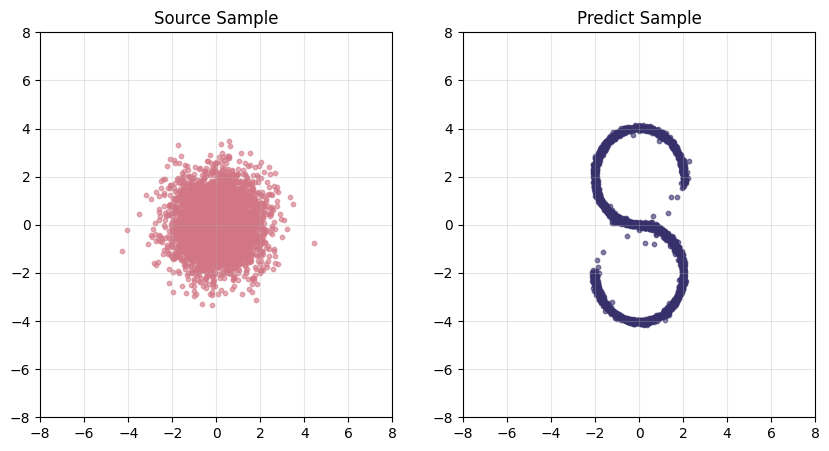

In [25]:
plot_source_and_target(pred_bridge[0, :, :], pred_bridge[-1, :, :], left_title="Source Sample", right_title="Predict Sample", save_path=log_dir / 'pred_bridge.jpg')

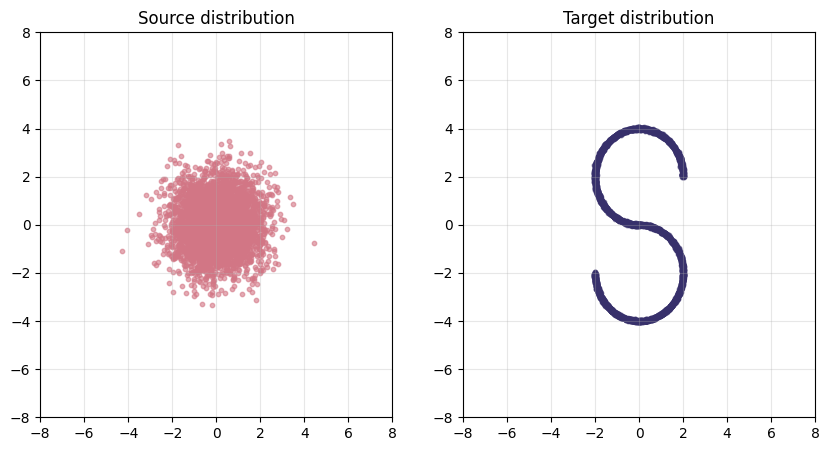

In [26]:
plot_source_and_target(test_bridge[0, :, :], test_bridge[-1, :, :], save_path=log_dir / 'gt_test_bridge.jpg')

In [27]:
save_gif_frame(pred_bridge, log_dir)

Output()